In [1]:
# imports 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5_utilities_module as h5u
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
import pingouin as pg
import warnings
from scipy.stats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
from statsmodels.tsa.api import VAR
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, alpha*100, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 100 - (alpha*100), axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val



def downsample_data(data, original_fs, target_fs=None, original_ts=None, step_size=None,
                   method='decimate', axis=-1, anti_aliasing=True, ftype='iir'):
    """
    Downsample time series data along specified axis.
    
    Parameters:
    -----------
    data: array - input data (can be multi-dimensional)
    original_fs: int - original sampling frequency in Hz
    target_fs: int - target sampling frequency in Hz (optional if step_size provided)
    original_ts: array - original timestamps (optional, will be generated if not provided)
    step_size: int - step size for downsampling (optional alternative to target_fs)
                     e.g., step_size=2 means keep every 2nd sample
    method: str - downsampling method ('decimate', 'resample', 'mean_pool')
    axis: int - axis along which to downsample (default: -1, last axis)
    anti_aliasing: bool - whether to apply anti-aliasing filter
    ftype: str - filter type for anti-aliasing ('iir' or 'fir')
    
    Returns:
    --------
    downsampled_data: array - downsampled data
    actual_fs: float - actual achieved sampling frequency
    new_ts: array - timestamps for downsampled data
    
    Notes:
    ------
    - Provide either target_fs OR step_size (not both)
    - If step_size is provided, target_fs is calculated as original_fs / step_size
    """
    
    # Handle step_size vs target_fs
    if step_size is not None and target_fs is not None:
        raise ValueError("Provide either target_fs OR step_size, not both")
    
    if step_size is not None:
        target_fs = original_fs / step_size
        print(f"Using step_size={step_size}, equivalent to target_fs={target_fs:.2f} Hz")
    
    if target_fs is None:
        raise ValueError("Must provide either target_fs or step_size")
    
    # Generate original timestamps if not provided
    if original_ts is None:
        original_length = data.shape[axis]
        original_ts = np.arange(original_length) / original_fs
    
    if target_fs >= original_fs:
        print(f"Warning: Target fs ({target_fs}) >= original fs ({original_fs}). Returning original data.")
        return data, original_fs, original_ts
    
    # Calculate downsampling factor
    downsample_factor = original_fs / target_fs
    
    if method == 'decimate':
        # Use scipy.signal.decimate for clean downsampling with anti-aliasing
        if downsample_factor != int(downsample_factor):
            # If not integer factor, use resample instead
            print(f"Non-integer downsample factor ({downsample_factor:.2f}), using resample method")
            method = 'resample'
        else:
            downsample_factor = int(downsample_factor)
            if anti_aliasing:
                downsampled_data = signal.decimate(data, downsample_factor, 
                                                 axis=axis, ftype=ftype)
            else:
                # Simple decimation without filtering
                slices = [slice(None)] * data.ndim
                slices[axis] = slice(None, None, downsample_factor)
                downsampled_data = data[tuple(slices)]
            
            # Downsample timestamps
            new_ts = original_ts[::downsample_factor]
            actual_fs = original_fs / downsample_factor
            
            return downsampled_data, actual_fs, new_ts
    
    if method == 'resample':
        # Use scipy.signal.resample for arbitrary resampling ratios
        original_length = data.shape[axis]
        target_length = int(original_length * target_fs / original_fs)
        
        downsampled_data = signal.resample(data, target_length, axis=axis)
        actual_fs = target_length * original_fs / original_length
        
        # Interpolate timestamps
        new_ts = np.linspace(original_ts[0], original_ts[-1], target_length)
        
        return downsampled_data, actual_fs, new_ts
    
    elif method == 'mean_pool':
        # Simple mean pooling (fastest but less precise)
        if downsample_factor != int(downsample_factor):
            raise ValueError("mean_pool method requires integer downsample factor")
        
        downsample_factor = int(downsample_factor)
        original_length = data.shape[axis]
        
        # Truncate to make length divisible by downsample_factor
        truncated_length = (original_length // downsample_factor) * downsample_factor
        
        slices = [slice(None)] * data.ndim
        slices[axis] = slice(0, truncated_length)
        truncated_data = data[tuple(slices)]
        
        # Reshape and take mean
        new_shape = list(truncated_data.shape)
        new_shape[axis] = truncated_length // downsample_factor
        new_shape.insert(axis + 1, downsample_factor)
        
        reshaped = truncated_data.reshape(new_shape)
        downsampled_data = np.mean(reshaped, axis=axis + 1)
        
        # Downsample timestamps (take center of each pooling window)
        new_ts = original_ts[:truncated_length:downsample_factor] + (downsample_factor - 1) / (2 * original_fs)
        actual_fs = original_fs / downsample_factor
        
        return downsampled_data, actual_fs, new_ts
    
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'decimate', 'resample', 'mean_pool'")


def transmission_analysis(data_A, data_B, lags, time_step, win_size):
    """
    Perform sliding window transmission analysis between two neural time series.

    Tests directional predictive relationships by applying lagged regression analysis
    within sliding temporal windows. Based on the approach described in Crowe et al. 
    (2013) Nature Neuroscience for detecting information transmission between brain areas.

    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
        Neural data from brain area A (e.g., posterior probabilities from decoding).
        Should be preprocessed (e.g., ARIMA whitened) to remove autocorrelation.
    data_B : ndarray, shape (n_trials, n_times)  
        Neural data from brain area B, same format as data_A.
    lags : array_like
        Lag values to test (in time bins). Should start from 0.
        e.g., np.arange(0, 9) tests lags 0-8 bins.
    time_step : float
        Time duration of each bin in milliseconds (e.g., 25.0 for 25ms bins).
    win_size : float  
        Sliding window size in milliseconds (e.g., 500.0 for 500ms windows).
        
    Returns
    -------
    a2b_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area A predicts area B at each lag and time step.
        Higher values indicate stronger predictive relationships.
    b2a_f : ndarray, shape (n_lags, n_time_steps)
        F-statistics testing whether area B predicts area A at each lag and time step.
    bin_centers : ndarray, shape (n_time_steps,)
        Indices of original time bins corresponding to the center of each sliding window.
        Maps columns in a2b_f/b2a_f back to original data time points. 
    """

    n_samples = int(win_size / time_step)  # Convert to integer
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1  # Number of valid window positions
    
    # Initialize result arrays [n_lags x n_times]
    a2b_f = np.full((len(lags), n_time_steps), np.nan)
    b2a_f = np.full((len(lags), n_time_steps), np.nan)
    
    # Calculate bin centers for each window position
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over valid window positions
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
       
        # Extract windows from all trials
        a_window = data_A[:, window_start:window_end]  # [trials x window_bins]
        b_window = data_B[:, window_start:window_end]  # [trials x window_bins]
       
        for lag_ix, this_lag in enumerate(lags):
           
            # Test A -> B
            if this_lag > 0:
                a_pred = a_window[:, :-this_lag].flatten()  # Earlier A values
                b_targ = b_window[:, this_lag:].flatten()   # Later B values
            else:
                a_pred = a_window.flatten()
                b_targ = b_window.flatten()
               
            # Test B -> A 
            if this_lag > 0:
                b_pred = b_window[:, :-this_lag].flatten()  # Earlier B values
                a_targ = a_window[:, this_lag:].flatten()   # Later A values
            else:
                b_pred = b_window.flatten()
                a_targ = a_window.flatten()
           
            # Run regressions and compute F-statistics
            if len(a_pred) > 10:  # Minimum data check
                try:
                    X = sm.add_constant(a_pred)
                    model = sm.OLS(b_targ, X).fit()
                    a2b_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
                   
            if len(b_pred) > 10:
                try:
                    X = sm.add_constant(b_pred)  
                    model = sm.OLS(a_targ, X).fit()
                    b2a_f[lag_ix, t_ix] = model.fvalue
                except:
                    pass
               
    return a2b_f, b2a_f, bin_centers



def shuffle_data(data, axis=-1):
    """
    Shuffle function that works with any axis and array shape.
    
    Parameters
    ----------
    data : ndarray
        Input data to shuffle
    axis : int, optional  
        Axis along which to shuffle. Default is -1 (last axis).
        
    Returns
    -------
    shuffled_data : ndarray
        Data shuffled along the specified axis
    """
    shuffled_data = data.copy()
    
    # Move the axis to shuffle to the last position
    shuffled_data = np.moveaxis(shuffled_data, axis, -1)
    
    # Get the shape and reshape to 2D for easier processing
    original_shape = shuffled_data.shape
    shuffled_data = shuffled_data.reshape(-1, original_shape[-1])
    
    # Shuffle each row (which corresponds to the moved axis)
    for i in range(shuffled_data.shape[0]):
        shuffled_data[i, :] = np.random.permutation(shuffled_data[i, :])
    
    # Reshape back and move axis back to original position
    shuffled_data = shuffled_data.reshape(original_shape)
    shuffled_data = np.moveaxis(shuffled_data, -1, axis)
    
    return shuffled_data


def granger_causality_analysis(data_A, data_B, max_lag, time_step, win_size):
    """
    Perform sliding window Granger causality analysis.
    
    Tests whether past values of A help predict B beyond what B's own past predicts.
    
    Parameters
    ----------
    data_A : ndarray, shape (n_trials, n_times)
    data_B : ndarray, shape (n_trials, n_times)
    max_lag : int
        Maximum number of lags to include (e.g., 8 for ~200ms if bins are 25ms)
    time_step : float
        Time duration of each bin in milliseconds
    win_size : float
        Sliding window size in milliseconds
        
    Returns
    -------
    a2b_f : ndarray, shape (n_time_steps,)
        F-statistics testing A→B causality (does A's past predict B?)
    b2a_f : ndarray, shape (n_time_steps,)
        F-statistics testing B→A causality (does B's past predict A?)
    a2b_p : ndarray, shape (n_time_steps,)
        P-values for A→B causality
    b2a_p : ndarray, shape (n_time_steps,)
        P-values for B→A causality
    bin_centers : ndarray, shape (n_time_steps,)
    """
    n_samples = int(win_size / time_step)
    n_trials, n_times = data_A.shape
    n_time_steps = n_times - n_samples + 1
    
    # Initialize result arrays
    a2b_f = np.full(n_time_steps, np.nan)
    b2a_f = np.full(n_time_steps, np.nan)
    a2b_p = np.full(n_time_steps, np.nan)
    b2a_p = np.full(n_time_steps, np.nan)
    
    bin_centers = np.arange(n_time_steps) + n_samples // 2
    
    # Loop over windows with progress bar
    for t_ix, window_start in enumerate(range(n_time_steps)):
        window_end = window_start + n_samples
        
        a_window = data_A[:, window_start:window_end]
        b_window = data_B[:, window_start:window_end]
        
        # Need enough data points for lags
        if n_samples <= max_lag + 1:
            continue
            
        try:
            # Test A → B (does A's past help predict B beyond B's own past?)
            
            # Create lagged predictors
            # B(t) is the target, we predict it from:
            # - B(t-1), B(t-2), ..., B(t-max_lag)  [B's own past]
            # - A(t-1), A(t-2), ..., A(t-max_lag)  [A's past]
            
            n_obs = n_samples - max_lag
            
            # Target: B at time t (from max_lag onwards)
            b_target = b_window[:, max_lag:].flatten()
            
            # Restricted model: B's own past only
            b_past = np.column_stack([
                b_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Full model: B's past + A's past
            a_past = np.column_stack([
                a_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Fit restricted model: B(t) ~ B(t-1) + ... + B(t-max_lag)
            X_restricted = sm.add_constant(b_past)
            model_restricted = sm.OLS(b_target, X_restricted).fit()
            
            # Fit full model: B(t) ~ B(t-1) + ... + A(t-1) + ...
            X_full = sm.add_constant(np.column_stack([b_past, a_past]))
            model_full = sm.OLS(b_target, X_full).fit()
            
            # F-test: does full model fit significantly better?
            # F = ((RSS_restricted - RSS_full) / num_added_params) / (RSS_full / df_full)
            rss_restricted = model_restricted.ssr
            rss_full = model_full.ssr
            df_full = model_full.df_resid
            num_added = max_lag  # Added A's lags
            
            f_stat = ((rss_restricted - rss_full) / num_added) / (rss_full / df_full)
            
            # P-value from F-distribution
            from scipy.stats import f as f_dist
            p_val = 1 - f_dist.cdf(f_stat, num_added, df_full)
            
            a2b_f[t_ix] = f_stat
            a2b_p[t_ix] = p_val
            
        except:
            pass
        
        try:
            # Test B → A (does B's past help predict A beyond A's own past?)
            a_target = a_window[:, max_lag:].flatten()
            
            a_past = np.column_stack([
                a_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            b_past = np.column_stack([
                b_window[:, max_lag-lag:-lag if lag > 0 else None].flatten()
                for lag in range(1, max_lag + 1)
            ])
            
            # Restricted: A(t) ~ A's past only
            X_restricted = sm.add_constant(a_past)
            model_restricted = sm.OLS(a_target, X_restricted).fit()
            
            # Full: A(t) ~ A's past + B's past
            X_full = sm.add_constant(np.column_stack([a_past, b_past]))
            model_full = sm.OLS(a_target, X_full).fit()
            
            rss_restricted = model_restricted.ssr
            rss_full = model_full.ssr
            df_full = model_full.df_resid
            num_added = max_lag
            
            f_stat = ((rss_restricted - rss_full) / num_added) / (rss_full / df_full)
            p_val = 1 - f_dist.cdf(f_stat, num_added, df_full)
            
            b2a_f[t_ix] = f_stat
            b2a_p[t_ix] = p_val
            
        except:
            pass
    
    return a2b_f, b2a_f, a2b_p, b2a_p, bin_centers


def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)


def random_prop_of_array(inarray, proportion_or_number):
    '''
    Randomly select a subset of True indices from a boolean array.
    
    INPUTS
    -------
    inarray : array-like, boolean
        Logical/boolean array of indices to potentially use later
    proportion_or_number : float or int
        If float between 0 and 1: proportion of True values to select
        If int >= 1: specific number of True values to select
    
    OUTPUT
    -------
    out_array : ndarray, boolean
        Logical/boolean that's set as True for the selected subset of the 
        initial True values in inarray
    
    EXAMPLES
    --------
    arr = np.array([True, True, False, True, True, False])
    random_prop_of_array(arr, 0.5)  # Select 50% of True values (2 out of 4)
    random_prop_of_array(arr, 2)    # Select exactly 2 True values
    '''
    out_array = np.zeros(shape=(len(inarray),))
    
    # Find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())
    
    # Determine how many indices to keep
    if isinstance(proportion_or_number, float) and 0 < proportion_or_number <= 1:
        # It's a proportion
        n_to_keep = round(len(shuffled_ixs) * proportion_or_number)
    elif isinstance(proportion_or_number, int) and proportion_or_number >= 1:
        # It's a specific number
        n_to_keep = min(proportion_or_number, len(shuffled_ixs))  # Don't exceed available
        if proportion_or_number > len(shuffled_ixs):
            print(f"Warning: Requested {proportion_or_number} trials but only {len(shuffled_ixs)} available. Using all.")
    else:
        raise ValueError("proportion_or_number must be a float between 0-1 or an integer >= 1")
    
    # Keep only the specified number
    kept_ix = shuffled_ixs[:n_to_keep]
    
    # Fill in the kept indices
    out_array[kept_ix] = 1
    
    # Make this a logical/boolean
    out_array = out_array > 0
    
    return out_array


def baseline_correct(data, baseline_idx):
    """
    Subtract the mean of baseline period from entire trace.
    Works with both 1D and 2D arrays.
    
    Parameters
    ----------
    data : ndarray
        Shape (n_trials, n_times) or (n_times,)
    baseline_idx : slice or array
        Indices defining the baseline period
        
    Returns
    -------
    data_corrected : ndarray
        Same shape as input, baseline-corrected
    """
    if data.ndim == 1:
        # 1D case
        baseline_mean = np.nanmean(data[baseline_idx])
        return data - baseline_mean
    else:
        # 2D case: compute baseline mean for each trial
        baseline_mean = np.nanmean(data[:, baseline_idx], axis=1, keepdims=True)
        return data - baseline_mean

In [3]:
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'
decoder_dir ='C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)
decoder_files = h5u.find_h5_files(decoder_dir)
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder\D20231219_Rec05.h5':
CdN_FR
CdN_channels
CdN_lfp
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_lfp
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
chan_map
lfp_ts
ts


In [4]:
bhv = pd.DataFrame()
all_ofc_lfp = []
all_cdn_lfp = []
ofc_amp = []
cdn_amp = []

for this_file in data_files:

    f_name = Path(this_file).stem
    print(f_name)

    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1

    # load the data
    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    ofc_lfp = np.clip(h5u.pull_from_h5(this_file, 'OFC_lfp'), -1e6, 1e6)
    cdn_lfp = np.clip(h5u.pull_from_h5(this_file, 'CdN_lfp'), -1e6, 1e6)
    lfp_ts = h5u.pull_from_h5(this_file, 'lfp_ts')

    # pull out the channels that have neurons on them
    ofc_unit_channels = np.unique(h5u.pull_from_h5(this_file, 'OFC_channels'))
    cdn_unit_channels = np.unique(h5u.pull_from_h5(this_file, 'CdN_channels'))

    # throw out LFP channels that didn't have neurons
    ofc_lfp = ofc_lfp[:, :, ofc_unit_channels.astype(int)]
    cdn_lfp = cdn_lfp[:, :, cdn_unit_channels.astype(int)]

    # zscore the lfp
    z_ofc_lfp = np.zeros((ofc_lfp.shape[0], len(lfp_ts), ofc_lfp.shape[2]), dtype='float32')
    z_cdn_lfp = np.zeros((ofc_lfp.shape[0], len(lfp_ts), cdn_lfp.shape[2]), dtype='float32')

    print('\nZ-scoring lfps...')
    for ch in tqdm(range(ofc_lfp.shape[2])):

        ofc_ch_mean = np.nanmean(ofc_lfp[:,:, ch])
        ofc_ch_std = np.nanstd(ofc_lfp[:,:, ch])

        z_ofc_lfp[:,:, ch] = (ofc_lfp[:,:, ch] - ofc_ch_mean) / ofc_ch_std

    for ch in tqdm(range(cdn_lfp.shape[2])):
        cdn_ch_mean = np.nanmean(cdn_lfp[:,:, ch])
        cdn_ch_std = np.nanstd(cdn_lfp[:,:, ch])

        z_cdn_lfp[:,:, ch] = (cdn_lfp[:,:, ch] - cdn_ch_mean) / cdn_ch_std

    # delete the original LFP
    del ofc_lfp
    del cdn_lfp

    # now take the mean LFP 
    ofc_mean_lfp = np.nanmean(z_ofc_lfp, axis=2)
    cdn_mean_lfp = np.nanmean(z_cdn_lfp, axis=2)

    # Replace NaN trials with zeros
    ofc_mean_lfp = np.nan_to_num(ofc_mean_lfp, nan=0.0)
    cdn_mean_lfp = np.nan_to_num(cdn_mean_lfp, nan=0.0)

    # BANDPASS FILTER at original sampling rate (1000 Hz)
    ofc_mean_lfp = bandpass_filter(ofc_mean_lfp, lowcut=4, highcut=20, fs=1000)
    cdn_mean_lfp = bandpass_filter(cdn_mean_lfp, lowcut=4, highcut=20, fs=1000)

    # downsample the data
    ofc_mean_lfp, new_fs, new_ts = downsample_data(
        ofc_mean_lfp, 
        original_fs=1000, 
        target_fs=40,
        original_ts=lfp_ts,
        method='decimate',
        axis=1
    )
    cdn_mean_lfp, _, _ = downsample_data(
        cdn_mean_lfp, 
        original_fs=1000, 
        target_fs=40,
        original_ts=lfp_ts,
        method='decimate',
        axis=1
)
    # now extract the analytic amplitude
    f_ofc_amp = np.abs(hilbert(ofc_mean_lfp, axis=1))
    f_cdn_amp = np.abs(hilbert(cdn_mean_lfp, axis=1))

    # DETREND THE AMPLITUDE (remove trial-averaged envelope)
    f_ofc_amp = f_ofc_amp - np.mean(f_ofc_amp, axis=0)
    f_cdn_amp = f_cdn_amp - np.mean(f_cdn_amp, axis=0)

    # now aggregate the data
    all_ofc_lfp.append(ofc_mean_lfp)
    all_cdn_lfp.append(cdn_mean_lfp)

    ofc_amp.append(f_ofc_amp)
    cdn_amp.append(f_cdn_amp)


# now convert back to arrays
all_ofc_lfp = np.concatenate(all_ofc_lfp, axis=0)
all_cdn_lfp = np.concatenate(all_cdn_lfp, axis=0)

ofc_amp = np.concatenate(ofc_amp, axis=0)
cdn_amp = np.concatenate(cdn_amp, axis=0)

D20231219_Rec05

Z-scoring lfps...


100%|██████████| 256/256 [00:11<00:00, 22.92it/s]


D20231221_Rec06

Z-scoring lfps...


100%|██████████| 222/222 [00:11<00:00, 19.31it/s]


D20231224_Rec07

Z-scoring lfps...


100%|██████████| 178/178 [00:08<00:00, 21.28it/s]


D20231227_Rec08

Z-scoring lfps...


100%|██████████| 184/184 [00:06<00:00, 28.81it/s]


K20240707_Rec06

Z-scoring lfps...


100%|██████████| 246/246 [00:11<00:00, 20.75it/s]


K20240710_Rec07

Z-scoring lfps...


100%|██████████| 258/258 [00:12<00:00, 21.03it/s]


K20240712_Rec08

Z-scoring lfps...


100%|██████████| 115/115 [00:04<00:00, 25.29it/s]


K20240715_Rec09

Z-scoring lfps...


100%|██████████| 106/106 [00:05<00:00, 21.03it/s]


In [5]:
single_ix = (bhv['n_sacc'] == 1) & (bhv['state'] < 3)
double_ix = (bhv['n_sacc'] == 2) & (bhv['state'] < 3)
d_ix = bhv['fname'].str.contains('D')
k_ix = bhv['fname'].str.contains('K') 

# truncate the amplitudes
amp_start = np.argmin(np.abs(new_ts - -1250))
amp_end = np.argmin(np.abs(new_ts - 1000))

truncated_ofc = ofc_amp[:, amp_start: amp_end]
truncated_cdn = cdn_amp[:, amp_start: amp_end]
truncated_ts = new_ts[amp_start:amp_end]

In [6]:
n_boots = 1000
win_len = 400
step = 25
max_lag = 4 # 25 ms each sample

# run one instance of the granger analysis to get array dimensions
_, _, _, _, time_indices = granger_causality_analysis(truncated_ofc[k_ix & double_ix,:], truncated_cdn[k_ix & double_ix,:], max_lag, step, win_len)

# initialize arrays for bootstraps
k_1_diff = np.zeros(shape=(n_boots, len(time_indices)))
k_2_diff = np.zeros(shape=(n_boots, len(time_indices)))
d_1_diff = np.zeros(shape=(n_boots, len(time_indices)))
d_2_diff = np.zeros(shape=(n_boots, len(time_indices)))


# loop over bootstraps
for b in tqdm(range(n_boots)):

    # grab a random sample of trials
    b_k_double_trials = random_prop_of_array(k_ix & double_ix, .9)
    b_k_single_trials = random_prop_of_array(k_ix & single_ix, int(np.sum(b_k_double_trials)))

    b_d_double_trials = random_prop_of_array(d_ix & double_ix, .9)
    b_d_single_trials = random_prop_of_array(d_ix & single_ix, int(np.sum(b_d_double_trials)))

    k1_ofc2cdn, k1_cdn2ofc, _, _, _ = granger_causality_analysis(truncated_ofc[b_k_single_trials,:], truncated_cdn[b_k_single_trials,:], max_lag, step, win_len)
    k2_ofc2cdn, k2_cdn2ofc, _, _, _ = granger_causality_analysis(truncated_ofc[b_k_double_trials,:], truncated_cdn[b_k_double_trials,:], max_lag, step, win_len)

    d1_ofc2cdn, d1_cdn2ofc, _, _, _ = granger_causality_analysis(truncated_ofc[b_d_single_trials,:], truncated_cdn[b_d_single_trials,:], max_lag, step, win_len)
    d2_ofc2cdn, d2_cdn2ofc, _, _, _ = granger_causality_analysis(truncated_ofc[b_d_double_trials,:], truncated_cdn[b_d_double_trials,:], max_lag, step, win_len)


    k_1_diff[b, :] = k1_ofc2cdn - k1_cdn2ofc
    k_2_diff[b, :] = k2_ofc2cdn - k2_cdn2ofc
    d_1_diff[b, :] = d1_ofc2cdn - d1_cdn2ofc
    d_2_diff[b, :] = d2_ofc2cdn - d2_cdn2ofc

# roll the data to account for the windowing effect
win_samples = int(win_len / step)  
shift = (win_samples // 2) + 1
k_1_diff = np.roll(k_1_diff, shift, axis=1)
k_2_diff = np.roll(k_2_diff, shift, axis=1)
d_1_diff = np.roll(d_1_diff, shift, axis=1)
d_2_diff = np.roll(d_2_diff, shift, axis=1)

100%|██████████| 1000/1000 [29:30<00:00,  1.77s/it]


In [7]:
# baseline correct the data
tx = truncated_ts[time_indices]

# Define baseline epoch 
baseline_start = np.argmin(np.abs(tx - -200))
baseline_end = np.argmin(np.abs(tx - -0))

# baseline correct the data relative to a time when there is no significant coherence 
# (and therefore any directional differences must be spurious)
baseline_ix = slice(baseline_start, baseline_end)
b_k_1_diff = baseline_correct(k_1_diff, baseline_ix)
b_k_2_diff = baseline_correct(k_2_diff, baseline_ix)
b_d_1_diff = baseline_correct(d_1_diff, baseline_ix)
b_d_2_diff = baseline_correct(d_2_diff, baseline_ix)

In [ ]:
k_1_mean, k_1_ci = calculate_mean_and_interval(b_k_1_diff, 'percentile')
k_2_mean, k_2_ci = calculate_mean_and_interval(b_k_2_diff, 'percentile')
d_1_mean, d_1_ci = calculate_mean_and_interval(b_d_1_diff, 'percentile')
d_2_mean, d_2_ci = calculate_mean_and_interval(b_d_2_diff, 'percentile')

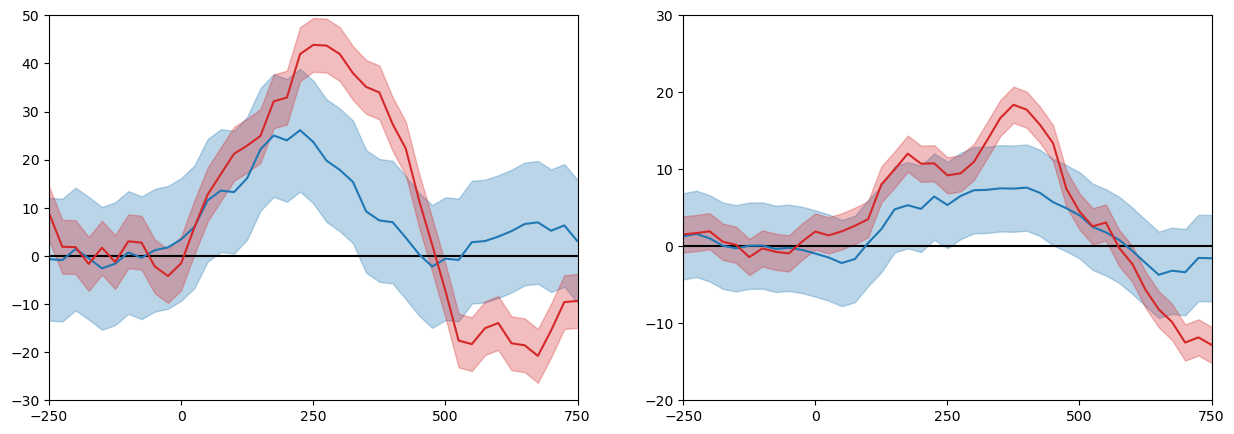

In [13]:
# Create a figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

single_col = 'tab:blue'
double_col = 'tab:red'

ax[0].plot([np.min(tx), np.max(tx)], [0,0], 'k')
ax[0].fill_between(tx, k_1_mean - k_1_ci, k_1_mean + k_1_ci, color = single_col, alpha=.3)
ax[0].plot(tx, k_1_mean, color = single_col)
ax[0].fill_between(tx, k_2_mean - k_2_ci, k_2_mean + k_2_ci, color = double_col, alpha=.3)
ax[0].plot(tx, k_2_mean, color = double_col)
ax[0].set_xlim(-250, 750)
ax[0].set_ylim(-30, 50)
ax[0].set_xticks((-250, 0, 250, 500, 750))

ax[1].plot([np.min(tx), np.max(tx)], [0,0], 'k')
ax[1].fill_between(tx, d_1_mean - d_1_ci, d_1_mean + d_1_ci, color = single_col, alpha=.3)
ax[1].plot(tx, d_1_mean, color = single_col)
ax[1].fill_between(tx, d_2_mean - d_2_ci, d_2_mean + d_2_ci, color = double_col, alpha=.3)
ax[1].plot(tx, d_2_mean, color = double_col)
ax[1].set_xlim(-250, 700)
ax[1].set_ylim(-20, 30)
ax[1].set_xticks((-250, 0, 250, 500, 750))

#fig.savefig('Granger_causality.svg')